# Homework 1
* Download: http://snap.stanford.edu/data/ca-GrQc.txt.gz

In [1]:
import snap
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
np.random.seed(2357)

# 1) Network Characteristics [25 points]

One of the goals of network analysis is to find mathematical models that characterize real-world
networks and that can then be used to generate new networks with similar properties. In this
problem, we will explore two famous models—Erdős-Rényi and Small World—and compare them
to real-world data from an academic collaboration network. Note that in this problem all networks
are undirected. You may use the starter code in hw1-q1-starter.py for this problem

### Erdős-Rényi Random graph (G(n, m) random network):
* Generate a random instance of this model by using n = 5242 nodes and picking m = 14484 edges at random. Write code to construct instances of this model, i.e., do not call a SNAP function.

In [3]:
def generate_edge(N):
    u = np.random.randint(N)
    v = np.random.randint(N)
    return u, v

def genErdosRenyi(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Erdos-Renyi graph with N nodes and E edges
    """
    ############################################################################
    # TODO: Your code here!
    Graph = snap.TUNGraph.New()
    
    for node_id in range(N):
        Graph.AddNode(node_id)
    
    edges = set()
    for _ in range(E):
        u, v = generate_edge(N)
        while ((u, v) in edges) or ((v, u) in edges) or (u == v):
            u, v = generate_edge(N)
        edges.add((u, v))
        Graph.AddEdge(u, v)

    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == E)
    ############################################################################
    return Graph

In [4]:
erdosRenyi = genErdosRenyi(5242, 14484)

### Small-World Random Network:

* Generate an instance from this model as follows: begin with n = 5242 nodes arranged as a ring, i.e., imagine the nodes form a circle and each node is connected to its two direct neighbors (e.g., node 399 is connected to nodes 398 and 400), giving us 5242 edges. Next, connect each node to the neighbors of its neighbors (e.g., node 399 is also connected to nodes 397 and 401). This gives us another 5242 edges. Finally, randomly select 4000 pairs of nodes not yet connected and add an edge between them. In total, this will make m = 5242 · 2 + 4000 = 14484 edges. Write code to construct instances of this model, i.e., do not call a SNAP function.

In [5]:
def genCircle(N=5242):
    """
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Circle graph with N nodes and N edges. Imagine the nodes form a
        circle and each node is connected to its two direct neighbors.
    """
    ############################################################################
    # TODO: Your code here!
    Graph = snap.TUNGraph.New()
    
    for node_id in range(N):
        Graph.AddNode(node_id)
    
    for node_id in range(N-1):
        Graph.AddEdge(node_id, node_id + 1)
    
    Graph.AddEdge(N - 1, 0)
    
    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == N)
    ############################################################################
    return Graph


def connectNbrOfNbr(Graph, N=5242):
    """
    :param - Graph: snap.PUNGraph object representing a circle graph on N nodes
    :param - N: number of nodes

    return type: snap.PUNGraph
    return: Graph object with additional N edges added by connecting each node
        to the neighbors of its neighbors
    """
    ############################################################################
    # TODO: Your code here!
    for node_id in range(N-2):
        Graph.AddEdge(node_id, node_id + 2)
    Graph.AddEdge(N - 2, 0)
    Graph.AddEdge(N - 1, 1)
    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == 2*N)
    ############################################################################
    return Graph


def connectRandomNodes(Graph, M=4000):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :param - M: number of edges to be added

    return type: snap.PUNGraph
    return: Graph object with additional M edges added by connecting M randomly
        selected pairs of nodes not already connected.
    """
    ############################################################################
    # TODO: Your code here!

    N = Graph.GetNodes()
    for _ in range(M):
        u, v = generate_edge(N)
        while (u == v) or Graph.IsEdge(u, v):
            u, v = generate_edge(N)
        Graph.AddEdge(u, v)
    assert (Graph.GetNodes() == N) and (Graph.GetEdges() == 2*N + M)
    ############################################################################
    return Graph


def genSmallWorld(N=5242, E=14484):
    """
    :param - N: number of nodes
    :param - E: number of edges

    return type: snap.PUNGraph
    return: Small-World graph with N nodes and E edges
    """
    Graph = genCircle(N)
    Graph = connectNbrOfNbr(Graph, N)
    Graph = connectRandomNodes(Graph, 4000)
    return Graph

In [6]:
smallWorld = genSmallWorld(5242, 14484)

### Real-World Collaboration Network:

* Download this undirected network from http://snap.stanford.edu/data/ca-GrQc.txt.gz. Nodes in this network represent authors of research papers on the arXiv in the General Relativity and Quantum Cosmology section. There is an edge between two authors if they have co-authored at least one paper together. Note that some edges may appear twice in the data, once for each direction. Ignoring repeats and self-edges, there are 5242 nodes and 14484 edges. (Note: Repeats are automatically ignored when loading an (un)directed graph with SNAP’s LoadEdgeList function).

In [7]:
def loadCollabNet(path):
    """
    :param - path: path to edge list file

    return type: snap.PUNGraph
    return: Graph loaded from edge list at `path and self edges removed

    Do not forget to remove the self edges!
    """
    ############################################################################
    # TODO: Your code here!
    Graph = snap.LoadEdgeList(snap.PUNGraph, path, 0, 1)
    
    snap.DelSelfEdges(Graph)
    
    assert (Graph.GetNodes() == 5242) and (Graph.GetEdges() == 14484)
    ############################################################################
    return Graph

In [8]:
collabNet = loadCollabNet("ca-GrQc.txt")

## 1.1) Degree Distribution [12 points]

Generate a random graph from both the Erdős-Rényi (i.e., G(n, m)) and Small-World models and
read in the collaboration network. Delete all of the self-edges in the collaboration network (there
should be 14,484 total edges remaining).
Plot the degree distribution of all three networks in the same plot on a log-log scale. In other words,
generate a plot with the horizontal axis representing node degrees and the vertical axis representing
the proportion of nodes with a given degree (by “log-log scale” we mean that both the horizontal
and vertical axis must be in logarithmic scale). In one to two sentences, describe one key difference
between the degree distribution of the collaboration network and the degree distributions of the
random graph models.

In [9]:
def getDataPointsToPlot(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    ############################################################################
    # TODO: Your code here!
    X, Y = [], []
    d = defaultdict(int)
    for node in Graph.Nodes():
        out_degree = node.GetOutDeg()
        d[out_degree] += 1
    d = dict(d)
    X, Y = zip(*sorted(d.items(), key=lambda x: x[0]))
    X, Y = list(X), [y/Graph.GetNodes() for y in Y]
    ############################################################################
    return X, Y


def Q1_1():
    """
    Code for HW1 Q1.1
    """
    erdosRenyi = genErdosRenyi(5242, 14484)
    smallWorld = genSmallWorld(5242, 14484)
    collabNet = loadCollabNet("ca-GrQc.txt")

    x_erdosRenyi, y_erdosRenyi = getDataPointsToPlot(erdosRenyi)
    plt.loglog(x_erdosRenyi, y_erdosRenyi, color='y', label='Erdos Renyi Network')

    x_smallWorld, y_smallWorld = getDataPointsToPlot(smallWorld)
    plt.loglog(x_smallWorld, y_smallWorld, linestyle='dashed', color='r', label='Small World Network')

    x_collabNet, y_collabNet = getDataPointsToPlot(collabNet)
    plt.loglog(x_collabNet, y_collabNet, linestyle='dotted', color='b', label='Collaboration Network')

    plt.xlabel('Node Degree (log)')
    plt.ylabel('Proportion of Nodes with a Given Degree (log)')
    plt.title('Degree Distribution of Erdos Renyi, Small World, and Collaboration Networks')
    plt.legend()
    plt.show()

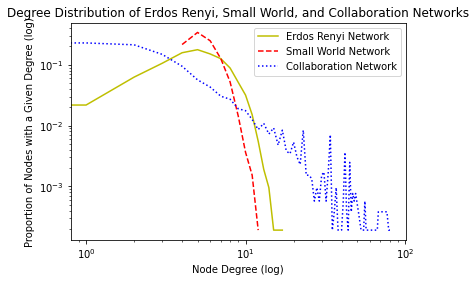

In [10]:
Q1_1()

## 1.2) Clustering Coefficient [13 points]

Compute and report the average clustering coefficient of the three networks. For this question,
write your own implementation to compute the clustering coefficient, instead of using a built-in
SNAP function.
Which network has the largest clustering coefficient? In one to two sentences, explain. Think about
the underlying process that generated the network.

In [11]:
def calcClusteringCoefficientSingleNode(Node, Graph):
    """
    :param - Node: node from snap.PUNGraph object. Graph.Nodes() will give an
                   iterable of nodes in a graph
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: local clustering coeffient of Node
    """
    ############################################################################
    # TODO: Your code here!
    C = 0.0
    k = Node.GetDeg()
    if k >= 2:
        e = 0
        for i in range(k):
            for j in range(i, k):
                u = Node.GetNbrNId(i)  # Returns ID of NodeN-th neighboring node 
                v = Node.GetNbrNId(j)
                if Graph.IsEdge(u, v):
                    e += 1
        C = 2*e / (k*(k-1))
    ############################################################################
    return C

def calcClusteringCoefficient(Graph):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: float
    returns: clustering coeffient of Graph
    """
    ############################################################################
    # TODO: Your code here! If you filled out calcClusteringCoefficientSingleNode,
    #       you'll probably want to call it in a loop here
    C = 0.0
    for node in Graph.Nodes():
        C += calcClusteringCoefficientSingleNode(node, Graph)
    C /= Graph.GetNodes()
    ############################################################################
    return C

def Q1_2():
    """
    Code for Q1.2
    """
    C_erdosRenyi = calcClusteringCoefficient(erdosRenyi)
    C_smallWorld = calcClusteringCoefficient(smallWorld)
    C_collabNet = calcClusteringCoefficient(collabNet)

    print('Clustering Coefficient for Erdos Renyi Network: %f' % C_erdosRenyi)
    print('Clustering Coefficient for Small World Network: %f' % C_smallWorld)
    print('Clustering Coefficient for Collaboration Network: %f' % C_collabNet)


# Execute code for Q1.2
Q1_2()

Clustering Coefficient for Erdos Renyi Network: 0.001608
Clustering Coefficient for Small World Network: 0.283923
Clustering Coefficient for Collaboration Network: 0.529636


# 4) Structural Roles: Rolx and ReFex [25 points]